# Part1. 트롤러 분석

In [1]:
#필요한 패키지 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
#데이터 셋, 아이템 정보 가져오기
data = pd.read_csv("C:/Users/yyop5/Desktop/esports 데이터 분석/last_project/ver1118.csv", index_col=0, encoding='CP949')
item_constant=requests.get("http://ddragon.leagueoflegends.com/cdn/11.19.1/data/en_US/item.json")

In [3]:
#가져온 아이템 정보를 DataFrame 형식으로 만들어주기
item_df=pd.DataFrame(item_constant.json()['data']).T['name'].rename_axis("key").reset_index()
item_df['key']=pd.to_numeric(item_df['key'])
item_df

,key,name
0,1001,Boots
1,1004,Faerie Charm
2,1006,Rejuvenation Bead
3,1011,Giant's Belt
4,1018,Cloak of Agility
...,...,...
194,6692,Eclipse
195,6693,Prowler's Claw
196,6694,Serylda's Grudge
197,6695,Serpent's Fang


In [4]:
data.head(3)

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,coreMinute,coreMinuteGoldDiff,isComebackWin,maxGoldDiffBeforeComeback,maxGoldDiffMinBeforeComeback,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData
0,327587836,2021-09-11 15:13:07,100,1,1,1,58,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
1,327587836,2021-09-11 15:13:07,100,2,1,2,102,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
2,327587836,2021-09-11 15:13:07,100,5,1,5,50,LOSE,0,14,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0


In [5]:
data.columns

Index(['gameId', 'createDate', 'teamId', 'summonerId', 'isUnknownSummoner',
       'participantId', 'championId', 'result', 'skinIndex', 'spell1',
       'spell2', 'leaver', 'experienceEarned', 'eligibleFirstWinOfDay',
       'ipEarned', 'boostXpEarned', 'boostIpEarned', 'premadeSize', 'item0',
       'item1', 'item2', 'item3', 'item4', 'item5', 'item6', 'level',
       'championsKilled', 'numDeaths', 'assists', 'neutralMinionsKilled',
       'turretsKilled', 'barracksKilled', 'minionsKilled', 'largestMultiKill',
       'largestCriticalStrike', 'largestKillingSpree', 'goldEarned',
       'physicalDamageDealtToChampions', 'magicDamageDealtPlayer',
       'physicalDamageTaken', 'sightWardsBoughtInGame',
       'visionWardsBoughtInGame', 'wardKilled', 'wardPlaced', 'totalHeal',
       'totalDamageDealtToChampions', 'totalDamageDealt', 'totalDamageTaken',
       'neutralMinionsKilledEnemyJungle', 'neutralMinionsKilledTeamJungle',
       'visionScore', 'timeCCingOthers', 'damageSelfMitigate

### (준비)분류를 위해 앞서 데이터 크기를 줄이기 위해 패배한 경기만 따로 추출

In [6]:
select=data[data['result']=='LOSE']
select=select.reset_index(drop=True, inplace=False)
select

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,coreMinute,coreMinuteGoldDiff,isComebackWin,maxGoldDiffBeforeComeback,maxGoldDiffMinBeforeComeback,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData
0,327587836,2021-09-11 15:13:07,100,1,1,1,58,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
1,327587836,2021-09-11 15:13:07,100,2,1,2,102,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
2,327587836,2021-09-11 15:13:07,100,5,1,5,50,LOSE,0,14,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
3,327587836,2021-09-11 15:13:07,100,9740283,0,4,523,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
4,327587836,2021-09-11 15:13:07,100,88586310,0,3,517,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494265,5442460252,2021-09-09 18:17:14,200,1123048,0,9,84,LOSE,0,14,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
494266,5442460252,2021-09-09 18:17:14,200,34530519,0,8,81,LOSE,0,1,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
494267,5442460252,2021-09-09 18:17:14,200,43880833,0,10,412,LOSE,0,14,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0
494268,5442460252,2021-09-09 18:17:14,200,77331043,0,6,777,LOSE,0,14,...,NaN,NaN,0,NaN,NaN,NaN,11.18.395.7538,0,1,0


## 1. 분당 데스 그래프 표현
분당 데스를 분 단위로 나누어서 계산하여 그래프를 통해 표현하는 작업을 진행했다. 여기서 그래프를 통해 데스 수의 기준을 올려 트롤인지 아닌지에 대한 데스 기준을 선정

In [7]:
#게임 시간을 초 단위에서 분 단위로 변경(나머지는 버림)
select['numDeaths']
select['gameLength']=select['gameLength']//60
select['gameLength']

0         25
1         25
2         25
3         25
4         25
          ..
494265    21
494266    21
494267    21
494268    21
494269    21
Name: gameLength, Length: 494270, dtype: int64

In [8]:
#분당으로 나온 시간을 보기위해 소수점 첫째자리만 사용
select['DeathPM']=np.round((select['numDeaths']/select['gameLength']),1)*10
select['DeathPM']
#ex) 5 : 분당 0.5데스(2분에 1데스)

0         4.0
1         2.0
2         5.0
3         2.0
4         5.0
         ... 
494265    3.0
494266    4.0
494267    3.0
494268    2.0
494269    6.0
Name: DeathPM, Length: 494270, dtype: float64

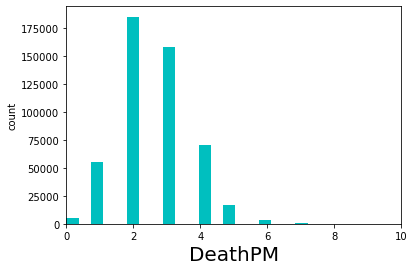

In [9]:
#트롤 기준을 선정하기 위해 전체적인 분포도를 표현
plt.hist(select['DeathPM'], color='c', bins=50)
plt.xlabel('DeathPM', fontsize=20)
plt.ylabel('count')
plt.xlim(0,10)
plt.show()

In [10]:
select['DeathPM'].quantile(0.85)

4.0

In [11]:
select['DeathPM'].describe()

count    494270.000000
mean          2.614549
std           1.070313
min           0.000000
25%           2.000000
50%           3.000000
75%           3.000000
max          18.000000
Name: DeathPM, dtype: float64

분당 데스가 3까진 많으나 4에서 부터 크게 수치가 줄어든다. 또한 3분위수까지는 분당 데스가 3으로 잡히고 있으므로 3은 평균적인 수치로 볼 수 있다. 따라서 분당데스가 4부터는 평균보다 높은 수치를 보이고 있으므로 분당 데스 4를 트롤의 분당 데스 기준으로 선정하게되었다.

## 2. 동일 아이템 비율 그래프 표현

먼저 동일 아이템 여부를 확인하기에 앞서 장신구 아이템이 포함되어 있으면 동일 아이템 여부가 나오지 않기 때문에 장신구 아이템의 위치를 확인했다.

In [12]:
#장신구 아이템 목록 위치 확인
select['item6']

0         3340
1         3364
2         3364
3         3340
4         3364
          ... 
494265    3364
494266    3340
494267    3364
494268    3363
494269    3364
Name: item6, Length: 494270, dtype: int64

In [13]:
accessory=item_df[item_df['key']==3340]
accessory=accessory.append(item_df[item_df['key']==3363], ignore_index=True)
accessory=accessory.append(item_df[item_df['key']==3364], ignore_index=True)
accessory

,key,name
0,3340,Stealth Ward
1,3363,Farsight Alteration
2,3364,Oracle Lens


item6에 위치한 아이템이 각각 와드 토템, 망원형 개조, 예언자의 렌즈라는 것을 확인할 수 있다. 따라서 item6 칼럼은 제외하고 비교를 진행했다.

In [14]:
#item0~item5까지 모든 아이템이 같은 경우 탐색해서 맞으면 True, 아니면 False
is_equal=[]
for i in select.index:
    if select.loc[i,'item0']==select.loc[i,'item1'] and select.loc[i,'item1']==select.loc[i,'item2'] and select.loc[i,'item2']==select.loc[i,'item3'] and select.loc[i,'item3']==select.loc[i,'item4'] and select.loc[i,'item4']==select.loc[i,'item5']:
        is_equal.append(True)
    else:
        is_equal.append(False)

In [15]:
#리스트로 만든 데이터를 데이터 프레임화 진행(T는 전치)
equal_count = len(is_equal)
df=pd.DataFrame([is_equal], index=['equal_item']).T
df

,equal_item
0,False
1,False
2,False
3,False
4,False
...,...
494265,False
494266,False
494267,False
494268,False


In [16]:
#동일 아이템 예시 확인
equal_select=pd.concat([select, df], axis=1)
equal_select[equal_select['equal_item']==True]
equal_select.loc[113,'item0':'item5']

item0    1036
item1    1036
item2    1036
item3    1036
item4    1036
item5    1036
Name: 113, dtype: object

In [17]:
#동일 아이템 목록
eq=equal_select[equal_select['equal_item']==True]
eq[['gameId','item0','item1','item2','item3','item4','item5','equal_item']]

,gameId,item0,item1,item2,item3,item4,item5,equal_item
99,327778967,0,0,0,0,0,0,True
113,5441720013,1036,1036,1036,1036,1036,1036,True
150,5441720048,2421,2421,2421,2421,2421,2421,True
324,5441720267,1029,1029,1029,1029,1029,1029,True
401,5441720327,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...
493531,5442459656,1042,1042,1042,1042,1042,1042,True
493565,5442459690,0,0,0,0,0,0,True
493580,5442459709,0,0,0,0,0,0,True
493657,5442459759,1006,1006,1006,1006,1006,1006,True


In [18]:
#불러온 item json파일을 통해 1036이 롱소드 아이템인걸 확인
item_df[item_df['key']==1036]

,key,name
12,1036,Long Sword


In [19]:
#동일 아이템 경우 확인
df.value_counts()

equal_item
False         491541
True            2729
dtype: int64

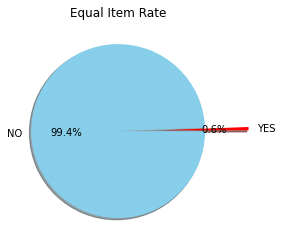

In [20]:
#동일 아이템 경우 비율로 확인
YES=len(equal_select[equal_select['equal_item']==True])
NO=len(equal_select[equal_select['equal_item']==False])

YES_rate=np.round(YES/(YES+NO),3)*100
NO_rate=np.round(NO/(YES+NO),3)*100
rate=[]
rate.append(YES_rate)
rate.append(NO_rate)
plt.pie(rate, labels=['YES','NO'], autopct="%0.1f%%", shadow=True, explode=(0.5,0), colors=['red','skyblue'])
plt.title('Equal Item Rate')
plt.show()

게임이 끝나는 기준으로 동일 아이템을 가지고 있는 소환사는 10000게임 중에서 0.6%인 약 60게임 정도로 굉장히 적은 비율이라는 것을 확인할 수 있다.

## 3. 시야 점수 비율 표현

In [21]:
#visionScore 열만을 따로 떼어 데이터 프레임 생성
select_vision=pd.DataFrame(select['visionScore'])

In [22]:
#각 visionScore에 따른 갯수를 카운트하여 리스트에 저장
select_vis=select_vision.value_counts().sort_index(ascending=True)

In [23]:
#데이터 프레임화 진행
select_vis=pd.DataFrame(select_vis, columns=['count'])
select_vis['count']=select_vis
select_vis=select_vis.reset_index()
select_vis.rename(columns={'index':'visionScore'}, inplace=True)
select_vis.columns

Index(['visionScore', 'count'], dtype='object')

<AxesSubplot:xlabel='visionScore', ylabel='count'>

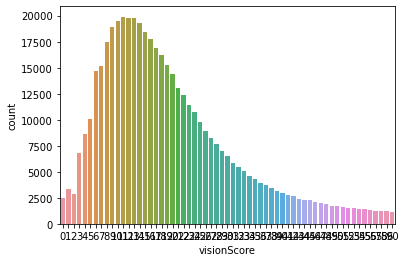

In [24]:
#시야 점수가 60이하인 경우에 대한 그래프 표현
select_vis60=select_vis[select_vis['visionScore']<=60]
sns.barplot(data=select_vis60, x='visionScore', y='count')

위 그래프를 통해 시야 점수의 비율이 2점에서 3점을 넘어가면서 급격히 오르는 것을 확인했다. 좀 더 명확하게 보기위해 시야 점수가 2점 이하인 경우와 아닌 경우에 따라 승률을 비교해서 나타내보았다.<br/>

In [25]:
#시야점수 2점이하인 경우와 아닌 경우 승률 비교하기
def winrate(data_input):
    win=np.round(len(data_input[data_input['result']=='WIN']),3)*100
    lose=np.round(len(data_input[data_input['result']=='LOSE']),3)*100
    plt.pie([win,lose], labels=['WIN','LOSE'], autopct="%0.1f%%", shadow=True, explode=(0.1,0), colors=['lightgreen','gold'])
    plt.show()

#### 시야 점수 2점 이하인 경우 승률

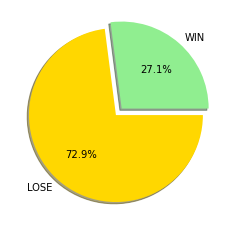

In [26]:
vision_2_down = winrate(data[data['visionScore']<=2])

#### 시야 점수 2점보다 높은 경우 승률

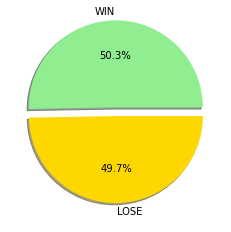

In [27]:
vision_2_up = winrate(data[data['visionScore']>2])

확인한 결과 시야 점수가 2점 이하인 경우와 아닌 경우의 승률 차이는 약 2배를 보이고 있다. 그만큼 시야 점수가 2점 이하인 경우에서 트롤이 많이 있다고 판단할 수 있기 때문에 2점을 트롤의 기준으로 잡았다.

## 4. 분당 데스, 시야 점수, 동일 아이템 여부를 합쳐서 트롤 추출

In [28]:
#분당 데스 0.5, 시야 점수 2이하, 동일 아이템을 기준으로 데이터 추출
DnV=equal_select[equal_select['DeathPM']>=4]
DnV=DnV[DnV['visionScore']<=2]
DnV=DnV[DnV['equal_item']==True]
DnV=DnV.reset_index(drop=True, inplace=False)
DnV

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,isComebackWin,maxGoldDiffBeforeComeback,maxGoldDiffMinBeforeComeback,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData,DeathPM,equal_item
0,5441721491,2021-09-09 10:07:16,200,85110678,0,9,85,LOSE,0,12,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,4.0,True
1,5441726170,2021-09-09 11:40:08,200,84989307,0,10,80,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,14.0,True
2,5441729377,2021-09-09 12:31:04,100,86760163,0,1,38,LOSE,0,11,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,5.0,True
3,5441921567,2021-09-09 10:12:03,100,86549472,0,4,55,LOSE,0,14,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,5.0,True
4,5441963266,2021-09-09 10:43:27,100,42600604,0,2,33,LOSE,0,1,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,6.0,True
5,5442026158,2021-09-09 11:40:44,100,67770355,0,5,222,LOSE,0,7,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,4.0,True
6,5442026310,2021-09-09 11:40:29,100,43621781,0,5,103,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,4.0,True
7,5442078655,2021-09-09 12:30:55,200,84228381,0,8,67,LOSE,0,12,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,4.0,True
8,5442118013,2021-09-09 14:39:10,100,83851055,0,2,55,LOSE,0,14,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,5.0,True
9,5442122493,2021-09-09 13:32:29,100,72950416,0,1,84,LOSE,0,14,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,4.0,True


In [29]:
DnV.loc[:,['numDeaths','DeathPM','visionScore','gameLength','item0','item1','item2','item3','item4','item5']]

,numDeaths,DeathPM,visionScore,gameLength,item0,item1,item2,item3,item4,item5
0,8,4.0,1,19,1055,1055,1055,1055,1055,1055
1,23,14.0,0,16,1006,1006,1006,1006,1006,1006
2,7,5.0,1,13,1004,1004,1004,1004,1004,1004
3,12,5.0,1,23,1052,1052,1052,1052,1052,1052
4,7,6.0,0,12,0,0,0,0,0,0
5,7,4.0,1,16,1055,1055,1055,1055,1055,1055
6,5,4.0,1,13,0,0,0,0,0,0
7,9,4.0,2,25,0,0,0,0,0,0
8,12,5.0,2,22,0,0,0,0,0,0
9,11,4.0,2,28,1056,1056,1056,1056,1056,1056


In [30]:
item_df[item_df['key']==1006]

,key,name
2,1006,Rejuvenation Bead


## 5. (미완성)서포터가 아닌데 박은 와드가 많은 경우(활용 X)

In [31]:
#서포터가 아닌 데이터 추출
not_sup=equal_select[equal_select['position']!='S']
not_sup

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,isComebackWin,maxGoldDiffBeforeComeback,maxGoldDiffMinBeforeComeback,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData,DeathPM,equal_item
0,327587836,2021-09-11 15:13:07,100,1,1,1,58,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,4.0,False
1,327587836,2021-09-11 15:13:07,100,2,1,2,102,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,False
3,327587836,2021-09-11 15:13:07,100,9740283,0,4,523,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,False
4,327587836,2021-09-11 15:13:07,100,88586310,0,3,517,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,5.0,False
5,327588952,2021-09-11 15:51:34,200,6,1,6,58,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,3.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494264,5442460251,2021-09-09 18:09:00,100,88055197,0,5,360,LOSE,0,4,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,3.0,False
494265,5442460252,2021-09-09 18:17:14,200,1123048,0,9,84,LOSE,0,14,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,3.0,False
494266,5442460252,2021-09-09 18:17:14,200,34530519,0,8,81,LOSE,0,1,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,4.0,False
494268,5442460252,2021-09-09 18:17:14,200,77331043,0,6,777,LOSE,0,14,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,False


In [32]:
#visionScore 열만을 따로 떼어 데이터 프레임 생성
not_sup_ward=pd.DataFrame(not_sup['wardPlaced'])

#각 visionScore에 따른 갯수를 카운트하여 리스트에 저장
not_sup_ward=not_sup.value_counts().sort_index(ascending=True)

#데이터 프레임화 진행
not_sup_ward=pd.DataFrame(select_vis, columns=['count'])
not_sup_ward['count']=not_sup_ward
not_sup_ward=not_sup_ward.reset_index()
not_sup_ward.rename(columns={'index':'wardPlaced'}, inplace=True)

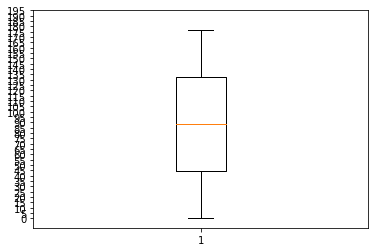

[array([44.25,  0.  ]), array([132.75, 177.  ])]


In [33]:
#박스 플롯으로 표현해 이상치가 나타나는 기준을 확인
fig, ax=plt.subplots()
box=ax.boxplot(not_sup_ward['wardPlaced'], notch=False, whis=1.5)
plt.yticks(np.arange(0, 200, step=5))
plt.show()

# Q1, Q3, min, max 값 정보
whiskers=[item.get_ydata() for item in box['whiskers']]

#여기서 Q1, min, Q3, max값 순서대로 출력
print(whiskers)

In [34]:
not_sup_ward['wardPlaced'].describe()

count    178.000000
mean      88.500000
std       51.528309
min        0.000000
25%       44.250000
50%       88.500000
75%      132.750000
max      177.000000
Name: wardPlaced, dtype: float64

여기서는 박스플롯으로 다른 값에 비해 크게 이상치로 나타나는 값이 없어서 제 3 사분위 값보다 큰 변수를 기준으로 잡아서 승률을 비교해보기로 했다

<AxesSubplot:xlabel='wardPlaced', ylabel='count'>

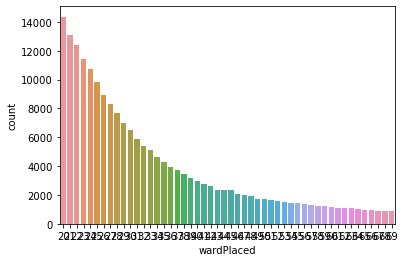

In [35]:
nsw=not_sup_ward[not_sup_ward['wardPlaced']<70]
sns.barplot(data=nsw[nsw['wardPlaced']>=20], x='wardPlaced', y='count')

In [36]:
#와드를 50개 이상 박은 경우
#quantile로 비율을 확인해서 눈에 띄는 구간을 비율로 잡아서 선정하기
not_sup=not_sup[not_sup['wardPlaced']>=50]
not_sup

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,isComebackWin,maxGoldDiffBeforeComeback,maxGoldDiffMinBeforeComeback,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData,DeathPM,equal_item
22633,5441863127,2021-09-09 11:02:43,200,79080732,0,10,106,LOSE,0,12,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,True
30891,5441921523,2021-09-09 10:12:02,100,8640996,0,5,72,LOSE,0,11,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,True
36171,5441926837,2021-09-09 11:55:31,100,56631946,0,1,84,LOSE,0,14,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,True
47648,5441949135,2021-09-09 13:02:33,100,84658936,0,4,27,LOSE,0,12,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,1.0,True
53439,5441955158,2021-09-09 11:30:22,100,60110267,0,1,59,LOSE,0,11,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,True
62123,5441964188,2021-09-09 11:31:10,100,85408255,0,1,16,LOSE,0,3,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,0.0,False
73604,5442025664,2021-09-09 11:42:01,200,83763638,0,9,23,LOSE,0,14,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,False
132730,5442142564,2021-09-09 13:23:48,200,5060269,0,6,2,LOSE,0,11,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,3.0,True
175941,5442182246,2021-09-09 13:34:31,100,79080732,0,1,875,LOSE,0,12,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,2.0,True
189355,5442194287,2021-09-09 13:56:07,100,11512062,0,3,2,LOSE,0,11,...,0,NaN,NaN,NaN,11.18.395.7538,0,1,0,3.0,True


In [37]:
not_sup.loc[:,['position','numDeaths','DeathPM','visionScore','wardPlaced','gameLength','item0','item1','item2','item3','item4','item5']]

,position,numDeaths,DeathPM,visionScore,wardPlaced,gameLength,item0,item1,item2,item3,item4,item5
22633,T,8,2.0,16,87,34,0,0,0,0,0,0
30891,J,4,2.0,13,79,24,0,0,0,0,0,0
36171,M,3,2.0,8,53,19,0,0,0,0,0,0
47648,T,3,1.0,38,134,47,0,0,0,0,0,0
53439,J,5,2.0,19,77,23,0,0,0,0,0,0
62123,A,1,0.0,91,78,41,2065,3860,0,3083,3158,8001
73604,T,5,2.0,13,60,26,2055,0,0,0,0,0
132730,J,5,3.0,3,58,19,0,0,0,0,0,0
175941,T,7,2.0,4,106,32,0,0,0,0,0,0
189355,J,7,3.0,18,51,25,0,0,0,0,0,0


## 6. 분당 받은 데미지에 따른 분류

In [38]:
#전체 받은 데미지
equal_select['totalDamageTaken']

0         23774
1         25411
2         21773
3         16518
4         30582
          ...  
494265    17176
494266    10598
494267    13297
494268    16649
494269    20135
Name: totalDamageTaken, Length: 494270, dtype: int64

In [39]:
#챔피언에게 가한 데미지
equal_select['totalDamageDealtToChampions']

0          8917
1         19232
2         18590
3         11506
4         16223
          ...  
494265     6097
494266     6258
494267     5232
494268    13797
494269    13690
Name: totalDamageDealtToChampions, Length: 494270, dtype: int64

In [40]:
equal_select['tDTPM']=equal_select['totalDamageTaken']//equal_select['gameLength']
#equal_select['tDDPM']=equal_select['totalDamageDealt']//equal_select['gameLength']
equal_select['tDDTCPM']=equal_select['totalDamageDealtToChampions']//equal_select['gameLength']
equal_select['DMT']=equal_select['tDDTCPM']-equal_select['tDTPM']

In [41]:
#DMT : 분당 챔피언에게 가한 데미지 - 분당 전체 받은 데미지
equal_select['DMT'].describe()

count    494270.000000
mean       -269.081455
std         277.463448
min       -1857.000000
25%        -456.000000
50%        -278.000000
75%         -96.000000
max        1861.000000
Name: DMT, dtype: float64

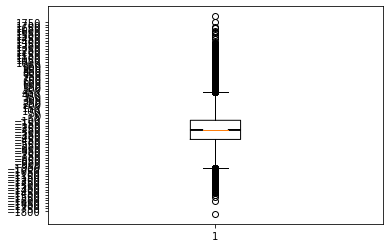

In [42]:
#박스 플롯으로 표현해 이상치가 나타나는 기준을 확인
fig, ax=plt.subplots()
boxplot=ax.boxplot(equal_select['DMT'], notch=True, whis=1.5)
plt.yticks(np.arange(-1800, 1800, step=50))
plt.show()

In [43]:
# Q1, Q3, min, max 값 정보
whiskers=[item.get_ydata() for item in boxplot['whiskers']]

In [44]:
#여기서 Q1, min, Q3, max값 순서대로 출력
print(whiskers)

[array([-456., -996.]), array([-96., 444.])]


위의 결과 값을 바탕으로 min보다 더 낮은 경우는 위의 boxplot에서 보다시피 이상치 값으로 나오게 됨으로 트롤의 DMT 기준을 -996으로 잡았다.

In [45]:
#위의 descirbe 값에 따라 -996이하인 데이터를 기준으로 잡음
equal_select[equal_select['DMT']<=-996]

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData,DeathPM,equal_item,tDTPM,tDDTCPM,DMT
1050,5441721026,2021-09-09 10:09:23,200,17062471,0,10,48,LOSE,0,11,...,NaN,11.18.395.7538,0,1,0,2.0,False,1895,591,-1304
1223,5441721167,2021-09-09 10:14:22,200,83674381,0,8,234,LOSE,0,4,...,NaN,11.18.395.7538,0,1,0,3.0,False,1494,396,-1098
1699,5441721587,2021-09-09 10:28:15,100,88529490,0,2,58,LOSE,0,14,...,NaN,11.18.395.7538,0,1,0,2.0,False,1460,410,-1050
1932,5441721819,2021-09-09 10:30:43,100,49660682,0,5,141,LOSE,0,11,...,NaN,11.18.395.7538,0,1,0,3.0,False,1634,635,-999
1983,5441721877,2021-09-09 10:21:32,100,83870575,0,3,64,LOSE,0,4,...,NaN,11.18.395.7538,0,1,0,3.0,False,1449,332,-1117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
492063,5442458298,2021-09-09 19:43:11,200,32084464,0,6,240,LOSE,0,12,...,NaN,11.18.395.7538,0,1,0,4.0,False,1603,536,-1067
492280,5442458512,2021-09-09 19:27:58,100,6930403,0,1,110,LOSE,0,7,...,NaN,11.18.395.7538,0,1,0,11.0,False,1473,83,-1390
492332,5442458534,2021-09-09 19:49:39,100,12590631,0,4,223,LOSE,0,12,...,NaN,11.18.395.7538,0,1,0,2.0,False,1592,518,-1074
493180,5442459321,2021-09-09 19:46:31,200,5922731,0,8,223,LOSE,0,12,...,NaN,11.18.395.7538,0,1,0,3.0,False,1656,598,-1058


### 종합. 위의 트롤러 기준, 추가적인 요소들을 바탕으로 트롤러 판별하여 데이터 프레임에 추가하기

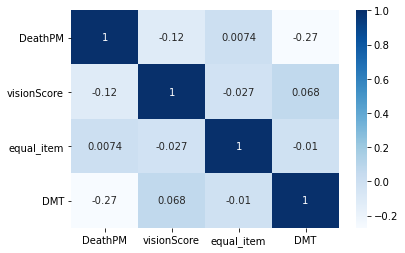

In [46]:
#판별 요소를 묶어주기 위한 heatmap을 통한 상관관계 확인
correlate=equal_select.loc[:,['DeathPM','visionScore','equal_item','DMT']]
correlate.corr()
sns.heatmap(correlate.corr(), annot=True, cmap="Blues")
plt.show()

위에서 정리한 요소를 바탕으로 상관관계를 나타내는 heatmap을 표시했다. 색이 진할수록 상관관계가 1에 가깝다.<br/><br/>
여기서 DMT와 DeathPM은 거의 흰색을 띄지만 서로 뚜렷한 음적 상관관계를 가지고 있어서 같이 묶어 주는 것이 좋다고 볼 수 있다.<br/>
위의 상관 관계에서 절대값이 0.01보다 더 작은 관계는 제외하고 묶어서 판별을 진행한다.<br/><br/>
판별 기준은 다음과 같이 정리 했다.<br/>
#### 1. 분당 데스 + DMT
#### 2. 분당 데스 + 시야 점수
#### 3. 시야 점수 + 동일 아이템
#### 4. 동일 아이템 + DMT

In [47]:
#기준에 따라 분류
is_troll=[]
for i in equal_select.index:
    #1. 분당 데스 + DMT
    if equal_select.loc[i, 'DeathPM']>=4 and equal_select.loc[i, 'DMT']<=-996:
        is_troll.append(1)
    #2. 분당 데스 + 시야 점수
    elif equal_select.loc[i, 'DeathPM']>=4 and equal_select.loc[i, 'visionScore']<=2:
        is_troll.append(1)
    #3. 시야 점수 + 동일 아이템
    elif equal_select.loc[i, 'visionScore']<=2 and equal_select.loc[i,'equal_item']==True:
        is_troll.append(1)
    #4. 동일 아이템 + DMT
    elif equal_select.loc[i, 'equal_item']==True and equal_select.loc[i,'DMT']<=-996:
        is_troll.append(1)    
    #그 외의 경우는 모두 트롤이 아님
    else:
        is_troll.append(0)

#리스트로 만든 데이터를 데이터 프레임화 진행(T는 전치)
troll_count = len(is_troll)
df_troll=pd.DataFrame([is_troll], index=['is_Troll']).T

In [48]:
df_troll

,is_Troll
0,0
1,0
2,0
3,0
4,0
...,...
494265,0
494266,0
494267,0
494268,0


In [49]:
#예시 확인
troll_select=pd.concat([equal_select, df_troll], axis=1)
troll_select

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,version,scanned,isFullData,isPlusData,DeathPM,equal_item,tDTPM,tDDTCPM,DMT,is_Troll
0,327587836,2021-09-11 15:13:07,100,1,1,1,58,LOSE,0,4,...,11.18.395.7538,0,1,0,4.0,False,950,356,-594,0
1,327587836,2021-09-11 15:13:07,100,2,1,2,102,LOSE,0,4,...,11.18.395.7538,0,1,0,2.0,False,1016,769,-247,0
2,327587836,2021-09-11 15:13:07,100,5,1,5,50,LOSE,0,14,...,11.18.395.7538,0,1,0,5.0,False,870,743,-127,0
3,327587836,2021-09-11 15:13:07,100,9740283,0,4,523,LOSE,0,4,...,11.18.395.7538,0,1,0,2.0,False,660,460,-200,0
4,327587836,2021-09-11 15:13:07,100,88586310,0,3,517,LOSE,0,4,...,11.18.395.7538,0,1,0,5.0,False,1223,648,-575,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494265,5442460252,2021-09-09 18:17:14,200,1123048,0,9,84,LOSE,0,14,...,11.18.395.7538,0,1,0,3.0,False,817,290,-527,0
494266,5442460252,2021-09-09 18:17:14,200,34530519,0,8,81,LOSE,0,1,...,11.18.395.7538,0,1,0,4.0,False,504,298,-206,0
494267,5442460252,2021-09-09 18:17:14,200,43880833,0,10,412,LOSE,0,14,...,11.18.395.7538,0,1,0,3.0,False,633,249,-384,0
494268,5442460252,2021-09-09 18:17:14,200,77331043,0,6,777,LOSE,0,14,...,11.18.395.7538,0,1,0,2.0,False,792,657,-135,0


In [50]:
#트롤 확인
troll_select[troll_select['is_Troll']==1]

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,version,scanned,isFullData,isPlusData,DeathPM,equal_item,tDTPM,tDDTCPM,DMT,is_Troll
16,327596752,2021-09-11 14:25:47,200,9,1,9,51,LOSE,0,4,...,11.18.395.7538,0,1,0,4.0,False,652,274,-378,1
250,5441720177,2021-09-09 09:18:42,100,14043480,0,3,266,LOSE,0,4,...,11.18.395.7538,0,1,0,6.0,False,970,441,-529,1
879,5441720810,2021-09-09 09:50:13,200,88323712,0,7,222,LOSE,0,7,...,11.18.395.7538,0,1,0,4.0,False,616,378,-238,1
979,5441720921,2021-09-09 09:41:37,100,88444666,0,5,777,LOSE,0,14,...,11.18.395.7538,0,1,0,4.0,False,460,163,-297,1
981,5441720930,2021-09-09 09:49:40,200,83364659,0,7,81,LOSE,0,7,...,11.18.395.7538,0,1,0,4.0,False,700,352,-348,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493854,5442459893,2021-09-09 19:41:04,100,87199902,0,2,92,LOSE,0,12,...,11.18.395.7538,0,1,0,5.0,False,1135,457,-678,1
493923,5442459946,2021-09-09 19:36:51,200,83284259,0,7,7,LOSE,0,14,...,11.18.395.7538,0,1,0,4.0,False,832,614,-218,1
493981,5442460014,2021-09-09 18:13:20,200,64600500,0,10,82,LOSE,0,4,...,11.18.395.7538,0,1,0,4.0,False,935,404,-531,1
494066,5442460090,2021-09-09 18:08:45,200,9014573,0,6,119,LOSE,0,14,...,11.18.395.7538,0,1,0,5.0,False,747,551,-196,1


In [51]:
check=troll_select[troll_select['is_Troll']==1]
check[['item0','item1','item2','item3','item4','item5','numDeaths','spell1','spell2','gameLength','DeathPM', 'position', 'visionScore', 'wardPlaced', 'DMT']]

,item0,item1,item2,item3,item4,item5,numDeaths,spell1,spell2,gameLength,DeathPM,position,visionScore,wardPlaced,DMT
16,1055,6672,1083,0,2422,0,6,4,7,16,4.0,A,2,1,-378
250,1054,3047,3044,1036,0,0,9,4,12,16,6.0,M,0,0,-529
879,1055,6672,3006,3086,1042,0,8,7,4,22,4.0,A,1,1,-238
979,2420,0,0,0,0,0,4,14,4,10,4.0,T,0,0,-297
981,1055,3057,3070,3067,3044,0,7,7,4,18,4.0,A,1,1,-348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493854,1055,3044,3071,3158,1037,1028,13,12,4,25,5.0,T,1,1,-678
493923,1056,6655,3020,0,0,0,9,14,4,21,4.0,M,1,0,-218
493981,2031,3157,6662,3158,0,0,7,4,11,19,4.0,J,1,1,-531
494066,1055,6670,1053,1001,1018,0,8,14,4,15,5.0,A,0,0,-196


위의 결과들을 바탕으로 총 3158명의 트롤러 판별을 확인했다.

# Part2. 트롤러 예측

## 1. 모델 학습
트롤러 분류를 결정적으로 예측하기위해 머신러닝을 사용한다. 여기서 사용한 모델은 로지스틱 회귀 모델인데 2개 이상의 독립 변수를 이용해 트롤인지 아닌지 참/거짓 여부를 학습 하기 위해서 다중 선형 회귀 모델인 로지스틱 회귀 모델을 사용했다.<br/>
모델 학습에 사용한 칼럼으론 <br/>
#### DeathPM(분당 데스), visionScore(시야 점수), equal_item(동일 아이템 여부), DMT(분당 챔피언에 입힌 데미지-분당 받은 데미지)<br/>
이렇게 4가지의 칼럼을 이용하여 분석을 진행했다.

In [52]:
#위에서 정리한 troll 판별까지 완료한 데이터 셋을 data_model로 복사
data_model=troll_select

In [53]:
#동일 아이템 여부에 대해서 True는 1, False는 0으로 변환(로지스틱 회귀 진행을 위해서 정수로 변환)
data_model['equal_item']=data_model['equal_item'].map({True:1, False:0})

In [54]:
#모델에 사용할 칼럼, 결과 칼럼 지정
features=data_model[['DeathPM', 'visionScore', 'equal_item', 'DMT']]
Troll = data_model['is_Troll']

In [55]:
features.dtypes

DeathPM        float64
visionScore      int64
equal_item       int64
DMT              int64
dtype: object

In [56]:
#train, test 셋 지정
train_fea, test_fea, train_lab, test_lab = train_test_split(features, Troll)

In [57]:
#분류를 위한 스케일러 활용
scaler=StandardScaler()

In [58]:
train_fea = scaler.fit_transform(train_fea)
test_fea=scaler.transform(test_fea)

In [59]:
#train 셋으로 로지스틱 회귀를 통한 학습 진행
model=LogisticRegression()
model.fit(train_fea, train_lab)

LogisticRegression()

In [60]:
#train 셋을 통한 모델의 정확도 확인
print(model.score(train_fea, train_lab))

0.9945158105432396


In [61]:
#test 셋을 통한 모델의 정확도 확인
print(model.score(test_fea, test_lab))

0.9946992748931762


In [62]:
print(model.coef_)

[[ 0.7303082  -9.54399381  0.17866375 -0.77862645]]


## 2. 새로운 데이터로 확인

In [63]:
predict_data = pd.read_csv("C:/Users/yyop5/Desktop/esports 데이터 분석/last_project/1119_100000.csv", index_col=0, encoding='CP949')

In [64]:
predict_data

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,coreMinute,coreMinuteGoldDiff,isComebackWin,maxGoldDiffBeforeComeback,maxGoldDiffMinBeforeComeback,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData
0,5467610005,2021-09-22 08:27:23,100,1978943,0,1,62,WIN,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
1,5467610005,2021-09-22 08:27:23,100,3210395,0,3,99,WIN,0,6,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
2,5467610005,2021-09-22 08:27:23,200,16580645,0,9,39,LOSE,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
3,5467610005,2021-09-22 08:27:23,200,30121392,0,7,102,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
4,5467610005,2021-09-22 08:27:23,100,35461935,0,4,876,WIN,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,5467731432,2021-09-22 09:42:10,100,8905204,0,4,117,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
99996,5467731432,2021-09-22 09:42:10,200,47730135,0,7,112,WIN,0,1,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
99997,5467731432,2021-09-22 09:42:10,100,54844599,0,5,104,LOSE,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
99998,5467731432,2021-09-22 09:42:10,100,86663064,0,3,40,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0


In [65]:
p_data=predict_data[predict_data['result']=='LOSE']
p_data=p_data.reset_index(drop=True, inplace=False)
p_data

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,coreMinute,coreMinuteGoldDiff,isComebackWin,maxGoldDiffBeforeComeback,maxGoldDiffMinBeforeComeback,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData
0,5467610005,2021-09-22 08:27:23,200,16580645,0,9,39,LOSE,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
1,5467610005,2021-09-22 08:27:23,200,30121392,0,7,102,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
2,5467610005,2021-09-22 08:27:23,200,59691006,0,8,266,LOSE,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
3,5467610005,2021-09-22 08:27:23,200,67970241,0,6,76,LOSE,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
4,5467610005,2021-09-22 08:27:23,200,83711491,0,10,7,LOSE,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48965,5467731432,2021-09-22 09:42:10,100,7941447,0,1,121,LOSE,0,14,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
48966,5467731432,2021-09-22 09:42:10,100,8905204,0,4,117,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
48967,5467731432,2021-09-22 09:42:10,100,54844599,0,5,104,LOSE,0,32,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0
48968,5467731432,2021-09-22 09:42:10,100,86663064,0,3,40,LOSE,0,4,...,NaN,NaN,0,NaN,NaN,NaN,11.19.398.2521,0,1,0


In [66]:
#DeathPM 만들기

#게임 시간을 초 단위에서 분 단위로 변경(나머지는 버림)
p_data['gameLength']=p_data['gameLength']//60
p_data['DeathPM']=p_data['gameLength']
p_data['gameLength']

#분당으로 나온 시간을 보기위해 소수점 첫째자리만 사용
p_data['DeathPM']=np.round((p_data['numDeaths']/p_data['gameLength']),1)*10
p_data['DeathPM']
#ex) 5 : 분당 0.5데스(2분에 1데스)

0        6.0
1        5.0
2        6.0
3        5.0
4        8.0
        ... 
48965    5.0
48966    4.0
48967    7.0
48968    5.0
48969    5.0
Name: DeathPM, Length: 48970, dtype: float64

In [67]:
#DMT 만들기

p_data['tDTPM']=p_data['totalDamageTaken']//p_data['gameLength']
p_data['tDDTCPM']=p_data['totalDamageDealtToChampions']//p_data['gameLength']
p_data['DMT']=p_data['tDDTCPM']-p_data['tDTPM']

In [68]:
#동일 아이템 만들기

#item0~item5까지 모든 아이템이 같은 경우 탐색해서 맞으면 True, 아니면 False
is_equal_p=[]
for i in p_data.index:
    if p_data.loc[i,'item0']==p_data.loc[i,'item1'] and p_data.loc[i,'item1']==p_data.loc[i,'item2'] and p_data.loc[i,'item2']==p_data.loc[i,'item3'] and p_data.loc[i,'item3']==p_data.loc[i,'item4'] and p_data.loc[i,'item4']==p_data.loc[i,'item5']:
        is_equal_p.append(True)
    else:
        is_equal_p.append(False)

#리스트로 만든 데이터를 데이터 프레임화 진행(T는 전치)
df=pd.DataFrame([is_equal_p], index=['equal_item']).T

#동일 아이템 예시 확인
p_data=pd.concat([p_data, df], axis=1)
p_data[p_data['equal_item']==True]


,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData,DeathPM,tDTPM,tDDTCPM,DMT,equal_item
187,5467610099,2021-09-22 08:41:30,200,74720362,0,10,555,LOSE,0,4,...,NaN,11.19.398.2521,0,1,0,4.0,630.0,229.0,-401.0,True
590,5467610289,2021-09-22 08:59:27,100,3735271,0,2,76,LOSE,0,11,...,NaN,11.19.398.2521,0,1,0,2.0,855.0,270.0,-585.0,True
657,5467610316,2021-09-22 08:57:26,100,82799838,0,4,67,LOSE,0,12,...,NaN,11.19.398.2521,0,1,0,4.0,737.0,532.0,-205.0,True
659,5467610316,2021-09-22 08:57:26,100,88607565,0,2,81,LOSE,0,7,...,NaN,11.19.398.2521,0,1,0,3.0,971.0,769.0,-202.0,True
681,5467610324,2021-09-22 08:57:30,200,10996779,0,7,64,LOSE,0,11,...,NaN,11.19.398.2521,0,1,0,2.0,937.0,756.0,-181.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48612,5467731266,2021-09-22 09:16:36,100,88675671,0,1,21,LOSE,0,6,...,NaN,11.19.398.2521,0,1,0,0.0,0.0,0.0,0.0,True
48652,5467731276,2021-09-22 09:37:56,200,86854829,0,8,21,LOSE,0,7,...,NaN,11.19.398.2521,0,1,0,4.0,1235.0,2116.0,881.0,True
48726,5467731314,2021-09-22 09:53:11,100,87990130,0,3,56,LOSE,0,12,...,NaN,11.19.398.2521,0,1,0,4.0,602.0,305.0,-297.0,True
48771,5467731333,2021-09-22 09:46:18,100,38352309,0,1,114,LOSE,0,4,...,NaN,11.19.398.2521,0,1,0,1.0,138.0,58.0,-80.0,True


In [69]:
#동일 아이템 여부에 대해서 True는 1, False는 0으로 변환(로지스틱 회귀 진행을 위해서 정수로 변환)
p_data['equal_item']=p_data['equal_item'].map({True:1, False:0})

In [70]:
p_data.dropna(subset=['DeathPM','visionScore','equal_item','DMT'], inplace=True)
p_data=p_data.reset_index(drop=True, inplace=False)
p_data

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,firstGoldLeadMinAfterComeback,version,scanned,isFullData,isPlusData,DeathPM,tDTPM,tDDTCPM,DMT,equal_item
0,5467610005,2021-09-22 08:27:23,200,16580645,0,9,39,LOSE,0,32,...,NaN,11.19.398.2521,0,1,0,6.0,1240.0,806.0,-434.0,0
1,5467610005,2021-09-22 08:27:23,200,30121392,0,7,102,LOSE,0,4,...,NaN,11.19.398.2521,0,1,0,5.0,1378.0,912.0,-466.0,0
2,5467610005,2021-09-22 08:27:23,200,59691006,0,8,266,LOSE,0,32,...,NaN,11.19.398.2521,0,1,0,6.0,1992.0,1224.0,-768.0,0
3,5467610005,2021-09-22 08:27:23,200,67970241,0,6,76,LOSE,0,32,...,NaN,11.19.398.2521,0,1,0,5.0,1125.0,896.0,-229.0,0
4,5467610005,2021-09-22 08:27:23,200,83711491,0,10,7,LOSE,0,32,...,NaN,11.19.398.2521,0,1,0,8.0,1415.0,999.0,-416.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48886,5467731432,2021-09-22 09:42:10,100,7941447,0,1,121,LOSE,0,14,...,NaN,11.19.398.2521,0,1,0,5.0,1520.0,2315.0,795.0,0
48887,5467731432,2021-09-22 09:42:10,100,8905204,0,4,117,LOSE,0,4,...,NaN,11.19.398.2521,0,1,0,4.0,1628.0,715.0,-913.0,0
48888,5467731432,2021-09-22 09:42:10,100,54844599,0,5,104,LOSE,0,32,...,NaN,11.19.398.2521,0,1,0,7.0,2258.0,2876.0,618.0,0
48889,5467731432,2021-09-22 09:42:10,100,86663064,0,3,40,LOSE,0,4,...,NaN,11.19.398.2521,0,1,0,5.0,1347.0,526.0,-821.0,0


In [71]:
#불러온 데이터에서 모델에 필요한 칼럼만 따로 추출
sample=p_data[['DeathPM', 'visionScore', 'equal_item', 'DMT']]

In [72]:
sample=sample.astype({'DMT':'int'})

In [73]:
#추출한 데이터 스케일러
sample=scaler.transform(sample)

In [74]:
#새로운 데이터를 통한 예측 진행
print(model.predict(sample))

[1 1 1 ... 0 1 1]


In [75]:
#예측 결과를 새로운 리스트에 저장
sample_predict=model.predict(sample)

In [76]:
#리스트를 DataFrame 변환을 하고 전치 변환을 통해 index 조절
sample_df=pd.DataFrame([sample_predict], index=['is_troll']).T
sample_df

,is_troll
0,1
1,1
2,1
3,0
4,1
...,...
48886,0
48887,1
48888,0
48889,1


In [77]:
#예측 결과를 새로 불러왔던 데이터에 합병하기
result_predict=pd.concat([p_data, sample_df], axis=1)
result_predict[result_predict['is_troll']==1]
result_predict

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,version,scanned,isFullData,isPlusData,DeathPM,tDTPM,tDDTCPM,DMT,equal_item,is_troll
0,5467610005,2021-09-22 08:27:23,200,16580645,0,9,39,LOSE,0,32,...,11.19.398.2521,0,1,0,6.0,1240.0,806.0,-434.0,0,1
1,5467610005,2021-09-22 08:27:23,200,30121392,0,7,102,LOSE,0,4,...,11.19.398.2521,0,1,0,5.0,1378.0,912.0,-466.0,0,1
2,5467610005,2021-09-22 08:27:23,200,59691006,0,8,266,LOSE,0,32,...,11.19.398.2521,0,1,0,6.0,1992.0,1224.0,-768.0,0,1
3,5467610005,2021-09-22 08:27:23,200,67970241,0,6,76,LOSE,0,32,...,11.19.398.2521,0,1,0,5.0,1125.0,896.0,-229.0,0,0
4,5467610005,2021-09-22 08:27:23,200,83711491,0,10,7,LOSE,0,32,...,11.19.398.2521,0,1,0,8.0,1415.0,999.0,-416.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48886,5467731432,2021-09-22 09:42:10,100,7941447,0,1,121,LOSE,0,14,...,11.19.398.2521,0,1,0,5.0,1520.0,2315.0,795.0,0,0
48887,5467731432,2021-09-22 09:42:10,100,8905204,0,4,117,LOSE,0,4,...,11.19.398.2521,0,1,0,4.0,1628.0,715.0,-913.0,0,1
48888,5467731432,2021-09-22 09:42:10,100,54844599,0,5,104,LOSE,0,32,...,11.19.398.2521,0,1,0,7.0,2258.0,2876.0,618.0,0,0
48889,5467731432,2021-09-22 09:42:10,100,86663064,0,3,40,LOSE,0,4,...,11.19.398.2521,0,1,0,5.0,1347.0,526.0,-821.0,0,1


In [78]:
#총 831명의 트롤러 확인
result_predict[result_predict['is_troll']==1]

,gameId,createDate,teamId,summonerId,isUnknownSummoner,participantId,championId,result,skinIndex,spell1,...,version,scanned,isFullData,isPlusData,DeathPM,tDTPM,tDDTCPM,DMT,equal_item,is_troll
0,5467610005,2021-09-22 08:27:23,200,16580645,0,9,39,LOSE,0,32,...,11.19.398.2521,0,1,0,6.0,1240.0,806.0,-434.0,0,1
1,5467610005,2021-09-22 08:27:23,200,30121392,0,7,102,LOSE,0,4,...,11.19.398.2521,0,1,0,5.0,1378.0,912.0,-466.0,0,1
2,5467610005,2021-09-22 08:27:23,200,59691006,0,8,266,LOSE,0,32,...,11.19.398.2521,0,1,0,6.0,1992.0,1224.0,-768.0,0,1
4,5467610005,2021-09-22 08:27:23,200,83711491,0,10,7,LOSE,0,32,...,11.19.398.2521,0,1,0,8.0,1415.0,999.0,-416.0,0,1
5,5467610007,2021-09-22 08:25:24,200,26002711,0,8,9,LOSE,0,32,...,11.19.398.2521,0,1,0,9.0,1597.0,1349.0,-248.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48854,5467731408,2021-09-22 09:33:26,200,87212986,0,8,104,LOSE,0,32,...,11.19.398.2521,0,1,0,8.0,1619.0,1329.0,-290.0,0,1
48885,5467731432,2021-09-22 09:42:10,100,1490977,0,2,517,LOSE,0,32,...,11.19.398.2521,0,1,0,7.0,2575.0,1353.0,-1222.0,0,1
48887,5467731432,2021-09-22 09:42:10,100,8905204,0,4,117,LOSE,0,4,...,11.19.398.2521,0,1,0,4.0,1628.0,715.0,-913.0,0,1
48889,5467731432,2021-09-22 09:42:10,100,86663064,0,3,40,LOSE,0,4,...,11.19.398.2521,0,1,0,5.0,1347.0,526.0,-821.0,0,1


In [79]:
col_check=result_predict[result_predict['is_troll']==1]
col_check=col_check[col_check['gameLength']>=3]

In [81]:
#완성된 데이터 셋에서 필요한 칼럼명만 따서 표현
col_check[['position','level','championsKilled','numDeaths','assists','wardPlaced','visionScore','gameLength','DeathPM','DMT','item0','item1','item2','item3','item4','item5', 'equal_item']]

,position,level,championsKilled,numDeaths,assists,wardPlaced,visionScore,gameLength,DeathPM,DMT,item0,item1,item2,item3,item4,item5,equal_item
0,NaN,14,9,9,8,0,0,15,6.0,-434.0,2031,3153,6673,3006,3077,3133,0
1,NaN,15,4,7,16,0,0,15,5.0,-466.0,3089,4636,3020,3145,0,0,0
2,NaN,13,7,9,12,0,0,15,6.0,-768.0,6630,1029,3111,3053,3211,0,0
4,NaN,14,6,12,11,0,0,15,8.0,-416.0,6655,3020,3157,3108,3067,1052,0
5,NaN,13,7,11,9,0,2,12,9.0,-248.0,4636,3157,3020,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48854,NaN,15,13,13,9,0,0,16,8.0,-290.0,6673,3006,6676,3072,1038,1018,0
48885,NaN,18,9,17,28,0,0,24,7.0,-1222.0,3157,6656,4629,3158,3165,4630,0
48887,NaN,18,7,10,48,0,0,24,4.0,-913.0,3083,3107,6617,3158,3504,6616,0
48889,NaN,18,2,12,49,0,0,24,5.0,-821.0,3107,6617,3011,3158,3504,6616,0
